Cameron Wood <br>
DTSA 5509 Final Project

GitHub Repo: https://github.com/cameronwood7/EMNIST_Supervised/tree/main

### **Project Rundown**

The EMNIST (Extended Modified National Institute of Standards and Technology) Letters Dataset is an extension of the well-known MNIST dataset, which is the bread and butter of machine learning benchmarking. What sets EMNIST apart is its larger size and, as the name suggests, its inclusion of handwritten letters. This project will focus on the letter component within this extended dataset. </br>

Image processing often relies on deep learning, which is CPU and GPU intensive. Through Supervised Learning, this project will show how we can create robust Classification models for handwritten letters. These models are more efficient and can be used on everyday machines, which would make them more accessible and useful for a broader audience. 

### **Data Description**

The EMNIST Dataset was derived from the NIST Special Database 19 and converted to the same format and structure as the MNIST dataset. The original NIST Special Database 19 was currated from 3600 writers, consists of 810,000 character images and their respective true labels. </br>

More details about the collection and conversion process is described in *EMNIST: an extension of MNIST to handwritten letters* by Gregory Cohen, et al. The data itself can be found within the paper referenced. </br>

In the EMNIST Letters dataset, there are 88,800 samples in 26 classes representing every letter in the alphabet, upper- and lower-case. The data is stored in a binary format that describes the image in terms of 8-bit gray-scale resolution. All images are 28x28 pixels in size. </br>

#### References: </br>
Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373 </br>


### **Data Cleaning**

First we can run the cell below to get all of the necessary packages.

In [71]:
# Importing Packages

import math
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Importing all necessary libraries

from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import uniform

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

%matplotlib inline

And then we can load in the data and check out what we're working with. We'll want to take note that the test dataset does not contain all of the letters in the alphabet, so we will just be using the training dataset and splitting it.

In [72]:
# Loading in the Dataset
data = pd.read_csv('emnist-letters-train.csv')

In [73]:
# Showing Data header
data.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It looks like our column header for our 'labels' is named '23' in the data, so we can fix that for data set. This will make it easier to reference later on in the code. </b>

We also notice that the labels are listed as integers 1-26 representing the entire alphabet. We will maintain this labeling method for ease of use.

In [74]:
#Renaming Labels Column
data = data.rename({'23':'labels'}, axis='columns')

# To Save on Compute we'll reduce the data to the first 10,000 images

data = data[:10000]

# We'll also want to rename all the pixel columns to be representative of that

count = 0

for i in data.columns:
    if (i != 'labels'):
        newName = 'pixel' + str(count)
        data = data.rename({i:newName}, axis='columns')
        count += 1

In [75]:
#Checking the training data
data.head()

,labels,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll want to check for any null values, and to make sure that the data types align with what we're expecting. This is so our models don't break down the line.

In [76]:
# Checking for Null Values
NullVal = data.isnull().sum()
print("For Train Data: ")
print(NullVal[NullVal != 0])

For Train Data: 
Series([], dtype: int64)


In [77]:
# Checking Data Types for the Data
print("Train Data: ")
print(data.info())

Train Data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, labels to pixel783
dtypes: int64(785)
memory usage: 59.9 MB
None


Lastly, we'll want to ensure that our pixel values contain intensity values, and that our training data has all 26 letters in it.

        pixel0   pixel1   pixel2   pixel3        pixel4        pixel5  \
count  10000.0  10000.0  10000.0  10000.0  10000.000000  10000.000000   
mean       0.0      0.0      0.0      0.0      0.006400      0.035400   
std        0.0      0.0      0.0      0.0      0.452526      2.497673   
min        0.0      0.0      0.0      0.0      0.000000      0.000000   
25%        0.0      0.0      0.0      0.0      0.000000      0.000000   
50%        0.0      0.0      0.0      0.0      0.000000      0.000000   
75%        0.0      0.0      0.0      0.0      0.000000      0.000000   
max        0.0      0.0      0.0      0.0     32.000000    183.000000   

             pixel6        pixel7        pixel8        pixel9  ...  pixel774  \
count  10000.000000  10000.000000  10000.000000  10000.000000  ...   10000.0   
mean       0.033500      0.041100      0.031500      0.007600  ...       0.0   
std        2.397614      2.678195      2.338986      0.544033  ...       0.0   
min        0.000000   

Text(0.5, 1.0, 'Histogram of EMNIST Data Set')

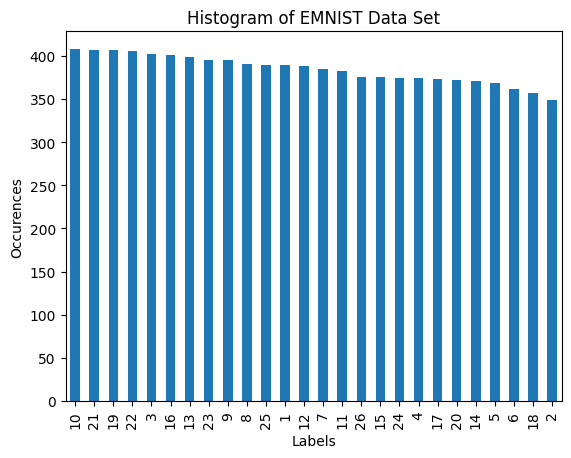

In [78]:
# For the training data
print(data.iloc[:, 1:].describe())

# Add Labels
ax = data['labels'].value_counts().plot(kind='bar')
ax.set_xlabel('Labels')
ax.set_ylabel('Occurences')
ax.set_title('Histogram of EMNIST Data Set')

Now that we have common column headers across both our dataset, we can now begin to work with the data in a meaningful way. EMNIST is a newer and less used dataset compared to MNIST, so it isn't as clean. We also confirmed that there are no null values within the dataset, and it consists of all integer values so we won't have any issues building our classification models. </br>

We also ensured that for the training and testing data sets have real intensity values in their pixels. We also ensured that there is an even distribution of letters within the data set, meaning we shouldn't have any bias towards a particular letter being trained on more significantly than any others. </br>

### **Exploratory Data Analysis**

Starting off we can split up our dataset into X, being our intensity values per pixel, and y, our labels. We'll also want to create an "alphabet" array to reference when accessing our labels.

In [79]:
# Seperating data from lables
X = data.drop('labels', axis=1).values
y = data['labels'].values

In [80]:
# Creating array of the alphabet
alphabet = []
for i in range(26):
    letter = chr(ord('a') + i)
    alphabet.append(letter)

Now we can use these new arrays to try plotting an example of what these handwritten letters look like. The images are flipped and rotated, so this is corrected in plotting. This fact won't change the classification models, since they are all in the same orientation.

In [81]:
# Method to view the letters at a specified index
def view_letter(data, label=None):
    fig = plt.figure(figsize=(3,3))
    data = np.flipud(data.reshape(28,28))
    data = np.rot90(data)
    data = np.rot90(data)
    data = np.rot90(data)
    plt.imshow(data, cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("True: {}".format(label), fontsize=16) 

In the cell below we can play with the index value and show a letter with it's true label.

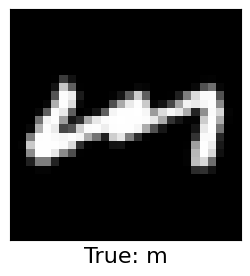

In [82]:
# Specify an index within the dataset and plot, along with specifying its true label
index = 5

view_letter(X[index], label=alphabet[y[index]-1])

Aside from the histogram showing the frequency of letters that show up in the dataset, found in the Data Cleaning section, we can also plot the intensities found across the dataset per letter.

Text(0.5, 1.0, 'Average Intensity Across EMNIST Dataset')

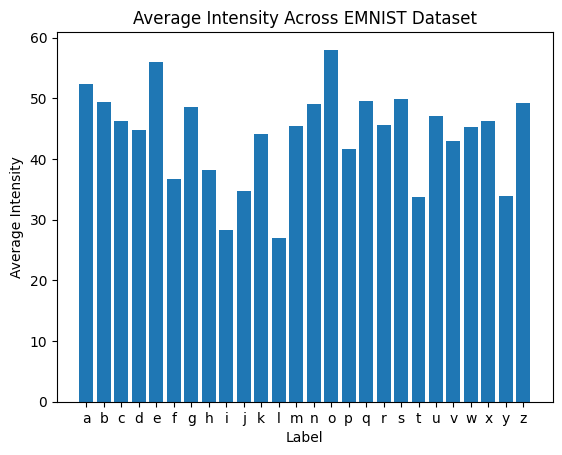

In [83]:
# Initialize arrays to store intensity values and counts
avg_intensity = np.zeros(26)
counts = np.zeros(26)

# Loop through X and gather information. Exlude intensity values of 0 which are black pixels

for i in range(len(X)):
    counts[y[i]-1] += 1
    avg_intensity[y[i]-1] += np.mean(X[i])

avg_intensity /= counts

# Plot a histogram of the intensity values

plt.bar(alphabet, avg_intensity)
plt.xlabel('Label')
plt.ylabel('Average Intensity')
plt.title('Average Intensity Across EMNIST Dataset')


We can see that there is quite a bit of variability in intensity between letters, but that is generally due to the size and shape of the letter written. For example, the letter i takes up significantly less space than something like a so the intensity is lower due to there being many more black pixels. </br>

Something else we can look at is the distribution of intensities across a particular letter. For this example I'll use the letter 'z' and compare it to 'o'.

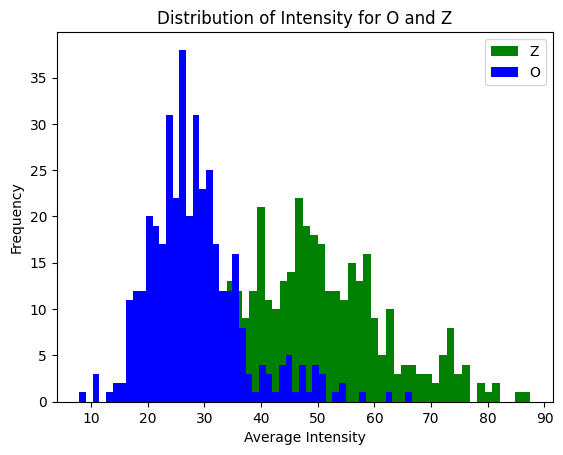

In [84]:
# Initialize Arrays
avg_intensity_z = []
avg_intensity_o = []

# Loop through the length and X and pick out any intensities that are Z or O
for i in range(len(X)):
    if y[i] == 26:
        avg_intensity_z.append(np.mean(X[i]))

    if y[i] == 9:
        avg_intensity_o.append(np.mean(X[i]))

# Plot the distribution of intensities                         
plt.hist(avg_intensity_z, bins=50, color='green', label='Z')
plt.hist(avg_intensity_o, bins=50, color='blue', label='O')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity for O and Z')
plt.legend()

As one might expect, there is higher variability in how someone might write the z versus how someone might write the letter o. The purpose of showing these distributions also helps to show feature seperability, which will allow us to better classify the letters.

In conclusion, we have found that our dataset contains proper distribution of letters so we don't introduce any training bias towards any particular letter. We were also able to take a look at what the images look like, along with the distribution of their features (intensity values). </br>

As expected, smaller and small letters, like i and l will have lower intensity values than larger letters like o and z. We were also able to compare the distribution of intensities for the letters o and z to show variability. A simple letter like o has less variation in how people write it, versus something like z. Depending on the models you are interested in using, this feature seperability can help in classification. It's also important to note that these distributions follow a mostly normal distribution, meaning that the data set is truly random with differing variability. </br>

As we move onto our models, there are forseen challenges with respect to this dataset. For some letters, as mentioned in the Project Rundown, we see both upper- and lower-case letters. This will increase variability, and make it harder for our basic classifiers to find common features between the two.

### **Models**

To start off, we'll split our data into training and testing sets. For our purposes we'll use a test size of 20%. </br>

It should be noted that due to the random nature of our letters chosen, and all images independent of one another, there is no collinearity between the data and this will not be an issue with the following models.

In [85]:
# Split the data into train and test sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

##### **Logistic Regression**

As our first classification model, we'll be using Logistic Regression. Logistic Regression models are great at baselining classification performance.

In [86]:
# We'll want to identify a list of hyperparameters to optimize while training the model

params = {
    'C': [0.01, 0.1, 1, 10], # Use a distribution of C values
    'penalty': ['l1','l2'], # Manipulate the penalty
    'solver': ['liblinear'] # Keep this one constant
}

# Set up grid search for the params and Logistic Regression
LogReg = GridSearchCV(LogisticRegression(), params, cv=5) # Use 5 cross-validation folds

# Create a Logistic Regression Model for the training data
LogReg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increas

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

Now that we have our best model through Grid Search, we'll want to save it off for use down the line.

In [87]:
# Saving off our best Logistic Model
LogReg_Best = LogReg.best_estimator_

# And the best params are
print(LogReg.best_params_)

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


##### **KNN**

K-Nearest Neighbors Classifiers are another great model to use that is basic while also providing easily interpretable results. 

In [96]:
# Similarly to our Logistic Regression Model, we will start off by selecting a list of hyperparameters to optimize for

params = {
    'n_neighbors': [1, 2, 3, 4, 5], # Lower k-values typically do better, and saves on compute
    'weights': ['uniform', 'distance'], # We want to test whether weighting our neighbors helps performance
    'metric': ['euclidean'], # We'll maintain euclidean distance throughout
    'leaf_size': [5, 10, 15] # We'll manipulate our leaf size
}

# Now we can set up our Grid Search and train our model
KNN = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy')

KNN.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15], 'metric': ['euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

And similarly to our Logistic Model, we'll want to save off our best KNN model found through Grid Search

In [99]:
# Save off our best KNN Model
KNN_Best = KNN.best_estimator_

# And the best parameters are

print(KNN.best_params_)

{'leaf_size': 5, 'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}


### **Results and Analysis**

Now that we have both of our models, we can begin to compare the performance through multiple lenses. To guide this discussion, we can start off with Confusion Matricies for the Log and KNN models.

Text(0.5, 1.0, 'KNN Confusion Matrix')

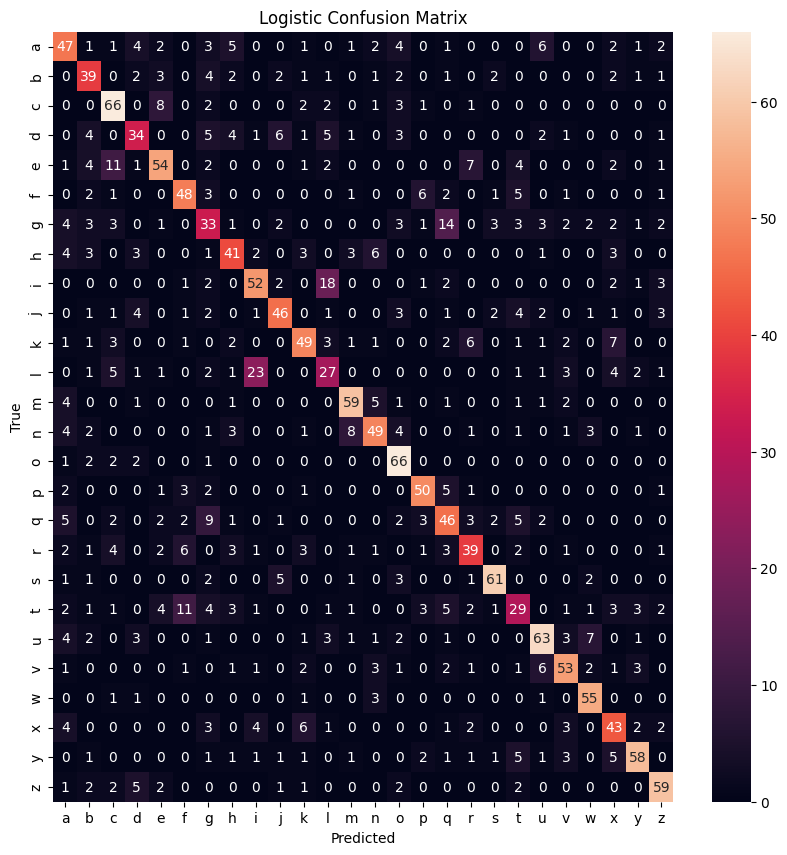

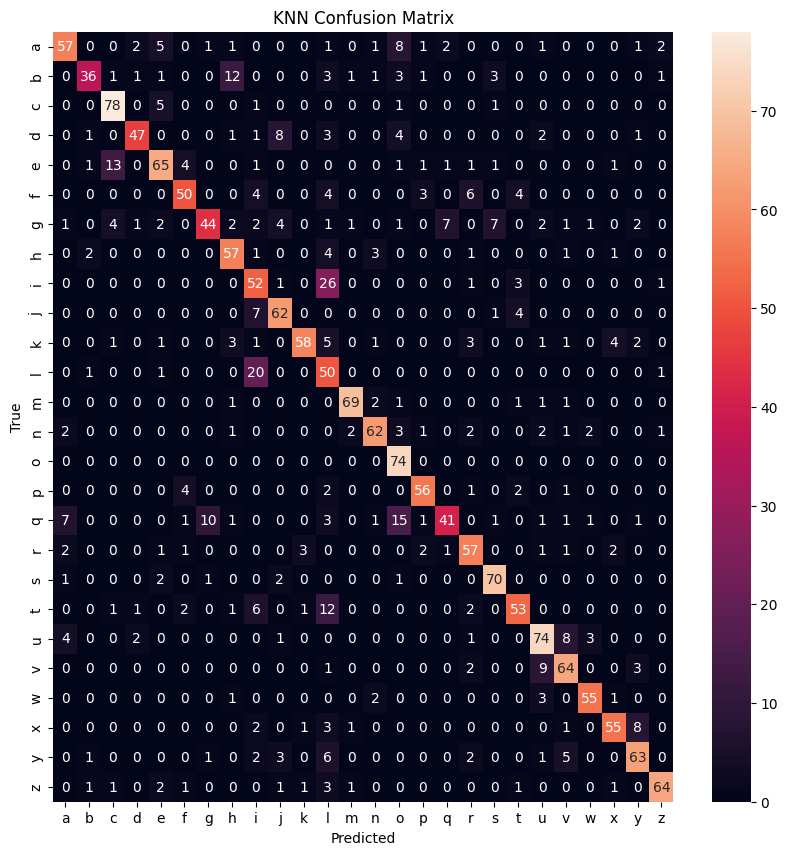

In [90]:
# First we can calculate the predictions
pred_Log = LogReg_Best.predict(X_test)
pred_KNN = KNN_Best.predict(X_test)

# Create the confusion matricies
cmLog = confusion_matrix(y_test, pred_Log)
cmKNN = confusion_matrix(y_test, pred_KNN)

# Plot the matricies as heat maps
# Log First
ax = plt
ax.figure(figsize=(10,10))
sns.heatmap(cmLog, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax.xlabel('Predicted')
ax.ylabel('True')
ax.title('Logistic Confusion Matrix')
# Now KNN
ax2 = plt
ax2.figure(figsize=(10,10))
sns.heatmap(cmKNN, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax2.xlabel('Predicted')
ax2.ylabel('True')
ax2.title('KNN Confusion Matrix')


As one may have expected, we see misclassifications in letters that look similar in both models: i, t and l, f and r, c and e. In all of their lower-case forms, they all follow a similar geometry when it comes to writing making it difficult for basic classifiers such as these to distinguish them 100% of the time. </br>

To get more granular, we will now look at the accuracy, precision, and recall for these models. Since this is a classification problem, we'll want to know how often we predicted correctly, how often our positive predictions were correct, and our models' abilities to correctly identify positive instances.

In [116]:
# Calculate metrics for LogReg_Best

prec_Log = precision_score(y_test, pred_Log, average=None)
rec_Log = recall_score(y_test, pred_Log, average=None)
acc_Log = accuracy_score(y_test, pred_Log)

print("Logistic Regression Model Stats: ")
print("Accuracy: ")
print(acc_Log)
print("Average Precision: ")
print(np.mean(prec_Log))
print("Recall: ")
print(np.mean(rec_Log))

# Calculate Metrics for KNN_Best

prec_KNN = precision_score(y_test, pred_KNN, average=None)
rec_KNN = recall_score(y_test, pred_KNN, average=None)
acc_KNN = accuracy_score(y_test, pred_KNN)

print(" ")
print("KNN Model Stats: ")
print("Accuracy: ")
print(acc_KNN)
print("Precision: ")
print(np.mean(prec_KNN))
print("Recall: ")
print(np.mean(rec_KNN))

Logistic Regression Model Stats: 
Accuracy: 
0.633
Average Precision: 
0.6318799137031311
Recall: 
0.6350563324966445
 
KNN Model Stats: 
Accuracy: 
0.7565
Precision: 
0.776984973452488
Recall: 
0.7588921484213712


From these numbers it's easy to see the KNN outperforms the Logistic Regression Model by quite a bit, in terms of the testing data. This is likely due to KNN being a non-parametric model, and the pixel values typically won't vary linearly. KNN also does well when features for specific classes are clustered together, which is the case for these handwritten letters. In summary, the Logistic Regression Model has an accuracy of 63.3%, an average Precision of 63.2%, and a recall of 63.4%. The KNN Model has an Accuracy of 75.7%, a Precision of 77.7%, and recall of 75.9%. </br>

Looking at the Best Models found using Grid Search, we can note a few things that may lead to our lack-luster performance for the Logistic Regression Model. For one, we have a fairly low C of 0.01 and are using Lasso penalization. The combination of these two prevents overfitting by setting certain coefficients to 0, effectively removing features. While this does create a simpler model, our dataset has a more complex set of features which may cause us some degredation in performance when it comes to misclassifying more complicated letters which have higher variance in the way they are written. Meanwhile for our KNN model, we find that a leaf size of 5. This also leads our model to be less prone to overfitting. Our most optimal number of neighbors is 4, while using distance weighting when selecting our prediction. This weighting allows us to be more precise, as we will have characteristics like feature clustering that Logistic Regression may not fully utilize.

For a step further, we can look at the Precision and Recall against all 26 letters by comparing the test data on the two models. This may give us more insight into why we see almost a 10% improvement in performance in the KNN model. The difference will be KNN - Log Regression Model.

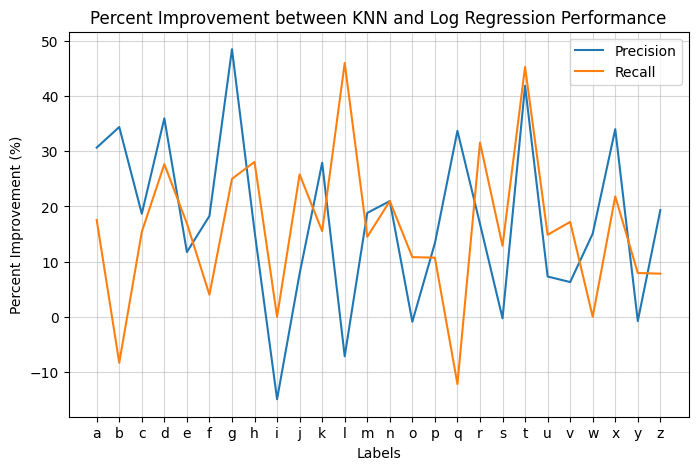

In [101]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_KNN - prec_Log)/prec_KNN
diff_recall = (rec_KNN - rec_Log)/rec_KNN

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between KNN and Log Regression Performance')
ax.grid(True, alpha=0.5)

As noted before, we see improvements in Precision and Recall across the board. In some cases, like the letter 'g', we see an improvement in precision by almost 50%. If we reference our Confusion Matrix above for Logistic Regression and KNN, we can see that often times in Logistic Regression 'g' would be misclassified as q. We can attribute this improvement to the over-generalization of our Logistic Regression model, where our model doesn't differentiate the nuances in how people write g versus q. On the flip side, however, we see that for q, our precision increased by almost 30%, but our Recall actually decreased by 10%. Within the KNN model, for some letters we might be over-generalizing, as for q we are now more likely to call false negatives and misclassify it as the letter o. </br>

Overall, both models performed farily well given the complex dataset and reduced number of sampling. We attained test accuracy scores of 63% for our Logistic Regression Model, and 76% for our KNN Model. Using Hyperparameter tuning we were able to tune things like the generalization factors in our Logistic Regression model, C being 0.01 and using Lasso penalization. For our KNN model, we chose a small leaf size to combat overfitting, along with a modest number of neighbors to be 4, utilizing distance weighting. Distance weighting is helpful for datasets with feature clustering, which the EMNIST dataset contains in terms of where the pixels are location between letters. While the KNN model performed better overall, it did have some degredation in Precision and Recall performance, but is limited to about a 10% reduction. When in comparison to the performance gain of up to 50% for some letters this is a great trade-off.

### **Discussion and Conclusion**

In the end, we achieved our main project goal: To show that we could build basic Supervised Learning Classifiers on complex datasets like EMNIST Letters. We were able to successfully clean, explore the data we were working with, train and test basic Classifier models, and attain moderate performance. While performance isn't at 95%+ levels, like some Convolutional Neural Nets might be able to achieve, our KNN model is able to achieve great results, at 76% test accuracy, with minimal feature engineering and some hyperparameter tuning. For the Logistic Regression model, with only a 63% test accuracy, I think it might be wise to focus more on feature engineering. Through hyperparameter tuning, I learned that the Logistic Regression model errs on the side of caution and favors over generalization to combat overfitting. While this would be good for less complex feature sets, this model is too simple to attain great results. We also learned that training a Logistic Regression model takes significantly more compute, taking almost 2 hours on my machine to train only 8,000 images, compared to less than a minute for KNN. I think if the mission is to create high performing models on everyday computers, KNN or something similar would be preferable. </br>

Moving forward, I think feature engineering up front may make it easier to process and classify the pixel data down the line. Something like normalizing all the pixels to be either black or white, and nothing in between. This would simplify the dataset, and allow for easier clustering in a model like KNN. As mentioned a couple times, this dataset contains both upper- and lower-case letters. For letters like a (a/A) where the variations aren't all too similar, it introduces complexity that these basic models. I might encourage using something like the EMNIST Balanced dataset that has these broken out into different classes, or make it part of the data cleaning process. Finally, this project did not train and test on the full dataset of 88,000 samples. This was done to save on computational time, but as we saw KNN took less than a minute to train, so maybe for a model similar an everyday computer could handle training on the increased number of samples. This increased training would help the classifier reach higher performance metrics. </br>

I think a lot can be taken from this project, and iterated upon to create high performing classifiers. A use case for something like this could be text-to-speech applications, where on the front end we have a camera taking in images of strings, some pre-processing to break those specific letters into smaller images to be classified. These models could also be paired with other models that could help with predicting the letter that's most likely using other context clues, like how close it is to dictionary words and whatnot. The applications for something like this are endless. 